In [1]:
 !pip install keras-tuner

# Import our dependencies
import pandas as pd
import matplotlib as plt
import sklearn as skl
import tensorflow as tf
from sklearn.datasets import make_circles

# Creating dummy nonlinear data
X_circles, y_circles = make_circles(n_samples=1000, noise=0.05, random_state=78)

# Transforming y_circles to a vertical vector
y_circles = y_circles.reshape(-1, 1)

# Use sklearn to split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_circles, y_circles, random_state=78)

# Create scaler instance
X_scaler = skl.preprocessing.StandardScaler()

# Fit the scaler
X_scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

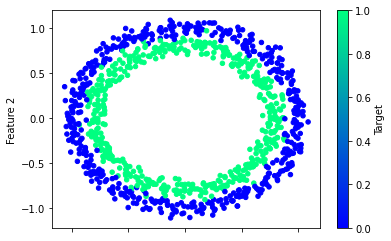

In [2]:
# Creating a DataFrame to plot the nonlinear dummy data
df_circles = pd.DataFrame(X_circles, columns=["Feature 1", "Feature 2"])
df_circles["Target"] = y_circles

# Plot the nonlinear dummy data
df_circles.plot.scatter(x="Feature 1",y="Feature 2", c="Target",colormap="winter")

In [3]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    # Allow kerastuner to decide which activation function to use in hidden layers
    nn_model = tf.keras.models.Sequential()
    activation = hp.Choice("activation",["relu", "tanh"])

    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int("first_units", min_value=1, max_value=30, step=5), activation=activation, input_dim=2))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int("num_layers", 1, 6)):
      nn_model.add(tf.keras.layers.Dense(units=hp.Int("units_"+str(i), min_value=1, max_value=30, step=5), activation=activation))

    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))
    
    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return nn_model

In [10]:
# Import the kerastuner library
import keras_tuner as kt

# Create a `Hyperband()` tuner instance
tuner = kt.Hyperband(create_model, objective="val_accuracy", max_epochs=20, hyperband_iterations=2, overwrite=True)

In [11]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled, y_train, epochs=20, validation_data=(X_test_scaled, y_test))

Trial 60 Complete [00h 00m 03s]
val_accuracy: 0.6399999856948853

Best val_accuracy So Far: 0.9639999866485596
Total elapsed time: 00h 02m 09s
INFO:tensorflow:Oracle triggered exit


In [12]:
# Get top 3 model hyperparameters and print the values
best_hyper = tuner.get_best_hyperparameters(3)

for param in best_hyper:
  print(param.values)

{'activation': 'relu', 'first_units': 11, 'num_layers': 4, 'units_0': 26, 'units_1': 11, 'units_2': 16, 'units_3': 16, 'units_4': 21, 'units_5': 6, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
{'activation': 'relu', 'first_units': 21, 'num_layers': 6, 'units_0': 11, 'units_1': 11, 'units_2': 6, 'units_3': 16, 'units_4': 21, 'units_5': 11, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': 'c7febffb3f5a55979c0f4b06bb927499'}
{'activation': 'tanh', 'first_units': 21, 'num_layers': 5, 'units_0': 11, 'units_1': 26, 'units_2': 6, 'units_3': 6, 'units_4': 11, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [13]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(X_test_scaled,y_test,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.1726 - accuracy: 0.9640
Loss: 0.17257235944271088, Accuracy: 0.9639999866485596
8/8 - 0s - loss: 0.3613 - accuracy: 0.9280
Loss: 0.36134520173072815, Accuracy: 0.9279999732971191
8/8 - 0s - loss: 0.4486 - accuracy: 0.9120
Loss: 0.4486112892627716, Accuracy: 0.9120000004768372


In [14]:
# Get second best model hyperparameters
second_hyper = tuner.get_best_hyperparameters(2)[1]
second_hyper.values

{'activation': 'relu',
 'first_units': 21,
 'num_layers': 6,
 'tuner/bracket': 1,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/round': 1,
 'tuner/trial_id': 'c7febffb3f5a55979c0f4b06bb927499',
 'units_0': 11,
 'units_1': 11,
 'units_2': 6,
 'units_3': 16,
 'units_4': 21,
 'units_5': 11}

In [15]:
# Compare the performance to the second-best model
second_model = tuner.get_best_models(2)[1]
model_loss, model_accuracy = second_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8/8 - 0s - loss: 0.3613 - accuracy: 0.9280
Loss: 0.36134520173072815, Accuracy: 0.9279999732971191
